In [1]:
import os 
import sys 
sys.path.append("../training")
import pickle
import copy

import hls4ml 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, auc, roc_curve

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
import tensorflow_model_optimization as tfmot

from qkeras.qlayers import QDense, QActivation
from qkeras import QBatchNormalization
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.utils import _add_supported_quantized_objects
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

# Local imports
from save_data import process_data

2024-03-27 13:43:13.751239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 13:43:13.862731: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-27 13:43:13.862758: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-03-27 13:43:14.354156: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'


/data/aelabd/miniforge3/envs/ml4qick-env/lib/python3.8/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


## Setup data

In [2]:
def one_hot_encode(data):
    y_encoded = np.zeros([data.shape[0],2], dtype=np.int32)
    for idx, x in enumerate(data):
        if x == 1:
            y_encoded[idx][1] = 1
        else:
            y_encoded[idx][0] = 1
    return y_encoded

In [3]:
START_WINDOW = 0
END_WINDOW = 770
DATA_DIR = "../data/data_0"

# convert raw ADC data into npy files 
if os.path.exists(f"{DATA_DIR}/X_train.npy") == False:
    process_data(
        start_window=START_WINDOW,
        end_window=END_WINDOW, 
        data_dir=DATA_DIR
    )

In [4]:
# load data
X_train_val = np.load(os.path.join(DATA_DIR, 'X_train.npy'))
X_test = np.load(os.path.join(DATA_DIR, 'X_test.npy'))    
y_train_val = np.load(os.path.join(DATA_DIR, 'y_train.npy'))
y_test = np.load(os.path.join(DATA_DIR, 'y_test.npy'))

y_train_val = one_hot_encode(y_train_val) # 1xN binary --> 2xN one-hot-encoded
y_test = one_hot_encode(y_test)

print("Training:")
print("\tSize:", len(X_train_val))
print("\tSample Shape:", len(X_train_val[0]))
print("\tMean:", X_train_val.mean())
print("\tStd. Dev.:", X_train_val.std())

print("Testing:")
print("\tSize:", len(X_test))
print("\tSample Shape:", len(X_test[0]))
print("\tSample Shape:", X_test.mean())
print("\tStd. Dev.:", X_test.std())

# X_train_val[0] = I, Q timeseries over (END_WINDOW - START_WINDOW) timesteps
assert len(X_train_val[0]) == (END_WINDOW-START_WINDOW)*2, "ERROR: Specified window does not match loaded dataset shape"
assert len(X_test[0]) == (END_WINDOW-START_WINDOW)*2, "ERROR: Specified window does not match loaded dataset shape"

Training:
	Size: 909000
	Sample Shape: 1540
	Mean: -50.80006179189348
	Std. Dev.: 1757.8248912271774
Testing:
	Size: 101000
	Sample Shape: 1540
	Sample Shape: -44.14494603317475
	Std. Dev.: 1756.0220686228422


In [5]:
X_train = copy.deepcopy(X_train_val)
print(X_train[0].shape)
print(max(X_train[0]))

print(sum(y_train_val[:,0]))
print(y_train_val.shape[0])

(1540,)
4644.0
455000
909000


## Construct a model 
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models. We're using QDense layer instead of Dense. We're also training with model sparsity, since QKeras layers are prunable.

In [6]:
INIT_LEARNING_RATE = 1e-2
VALIDATION_SPLIT = 0.3
BATCH_SIZE = 12800
EPOCHS = 50
CHECKPOINT_FILENAME = "qmodel.h5"
INPUT_SHAPE = (len(X_train_val[0]),)
print(INPUT_SHAPE)

(1540,)


In [7]:
# Define model with quantize layers 
model = Sequential()
model.add(QDense(2, input_shape=INPUT_SHAPE, name='fc1', kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),))
model.add(BatchNormalization())

# adding pruning 
pruning_params = {'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50, final_sparsity=0.80, begin_step=200, end_step=1000)}
model = prune.prune_low_magnitude(model, **pruning_params)

print('=============================Model Summary=============================')
print(model.summary())
print('=======================================================================')

2024-03-27 13:43:50.756980: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-27 13:43:50.757047: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-27 13:43:50.757105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator3.fnal.gov): /proc/driver/nvidia/version does not exist
2024-03-27 13:43:50.757684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
=============================Model Summary=============================
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_fc1 (Pr  (None, 2)                6164      
 uneLowMagnitude)                                                
                                                                 
 prune_low_magnitude_batch_n  (None, 2)                9         
 ormalization (PruneLowMagni                                     
 tude)                                                           
                                                                 
Total params: 6,173
Trainable params: 3,086
Non-trainable params: 3,087
_________________________________________

In [8]:
callbacks = [
        ModelCheckpoint(
        CHECKPOINT_FILENAME,
        monitor="val_loss",
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        save_freq="epoch",
    ),
    ReduceLROnPlateau(patience=75, min_delta=1**-6),
    pruning_callbacks.UpdatePruningStep(),
]


## Train the model 

In [9]:
opt = Adam(learning_rate=INIT_LEARNING_RATE)
model.compile(
    optimizer=opt, 
    # loss=tf.keras.losses.BinaryCrossentropy(),
    loss=CategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

history = model.fit(
    X_train_val, 
    y_train_val, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS, 
    validation_split=VALIDATION_SPLIT, 
    shuffle=True, 
    callbacks=callbacks
)

2024-03-27 13:44:00.397412: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3919608000 exceeds 10% of free system memory.


Epoch 1/50
50/50 [==============================] - 5s 76ms/step - loss: 0.2275 - accuracy: 0.9463 - val_loss: 0.3154 - val_accuracy: 0.8713 - lr: 0.0100
Epoch 2/50
50/50 [==============================] - 2s 39ms/step - loss: 0.1738 - accuracy: 0.9607 - val_loss: 0.2028 - val_accuracy: 0.9429 - lr: 0.0100
Epoch 3/50
50/50 [==============================] - 2s 39ms/step - loss: 0.1626 - accuracy: 0.9624 - val_loss: 0.1702 - val_accuracy: 0.9588 - lr: 0.0100
Epoch 4/50
50/50 [==============================] - 2s 39ms/step - loss: 0.1589 - accuracy: 0.9633 - val_loss: 0.1745 - val_accuracy: 0.9625 - lr: 0.0100
Epoch 5/50
50/50 [==============================] - 2s 40ms/step - loss: 0.1597 - accuracy: 0.9637 - val_loss: 0.1632 - val_accuracy: 0.9631 - lr: 0.0100
Epoch 6/50
50/50 [==============================] - 2s 39ms/step - loss: 0.1583 - accuracy: 0.9637 - val_loss: 0.1733 - val_accuracy: 0.9609 - lr: 0.0100
Epoch 7/50
50/50 [==============================] - 2s 39ms/step - loss: 0.1

Important: Pruning layers must be removed before saving to disk. 

In [10]:
model = strip_pruning(model)
model.save(CHECKPOINT_FILENAME)

history_file = CHECKPOINT_FILENAME.replace(".h5", "-history.pkl")
with open(history_file, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

print(f'Saving history to: {history_file}')
print(f'Saved checkpoint to: {CHECKPOINT_FILENAME}')

Saving history to: qmodel-history.pkl
Saved checkpoint to: qmodel.h5


## Check performance

In [11]:
co = {}
_add_supported_quantized_objects(co)
model = load_model(CHECKPOINT_FILENAME, custom_objects=co, compile=False)
y_pred = model.predict(X_test)
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))))

3157/3157 [==============================] - 3s 915us/step
Keras  Accuracy: 0.9613960396039604


todo: add ROC curve

To add an ROC curve, we need to normalize $y_\text{pred} \in [0,1]$. Right now it can take a range of values (I'm guessing because sigmoid is too expensive to run on hardware, whereas argmax can be implemented with basically just a switch).

So then, what's an unbiased way to get back to $y_\text{pred} \in [0,1]$? 

In [19]:
print(y_pred[:10])
print(y_test[:10])

# y_pred_roc = np.argmax(y_pred, axis=1)
# y_test_roc = np.argmax(y_test, axis=1)
#y_pred_roc = one_hot_encode(np.argmax(y_pred, axis=1))
#y_test_roc = one_hot_encode(np.argmax(y_test, axis=1))
# y_test

# print(y_pred_roc[:10])
# print(y_test_roc[:10])

# roc_ = roc_curve(y_test_roc, y_pred_roc, pos_label=1)
# print(roc_)
# auc_score = auc(false_pos_rate, true_pos_rate)

# plt.figure()
# plt.plot(false_pos_rate, true_pos_rate)
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title(f"AUC: = {auc_score}")
# plt.savefig("roc_curve.png")
# plt.show()

[[-2.5286386   2.8676906 ]
 [-2.5049384   0.7283654 ]
 [-3.2544324   2.8117013 ]
 [-1.4842231   1.5737374 ]
 [-1.3367517   2.5866237 ]
 [-0.64492106  1.2184055 ]
 [-3.0617778   4.063533  ]
 [-1.754684    0.11622918]
 [-2.140119    3.2486    ]
 [-1.1152425   1.8391492 ]]
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]


## Check sparsity 

Number of layers: 2
% of zeros = 0.8
% of zeros = 0.0


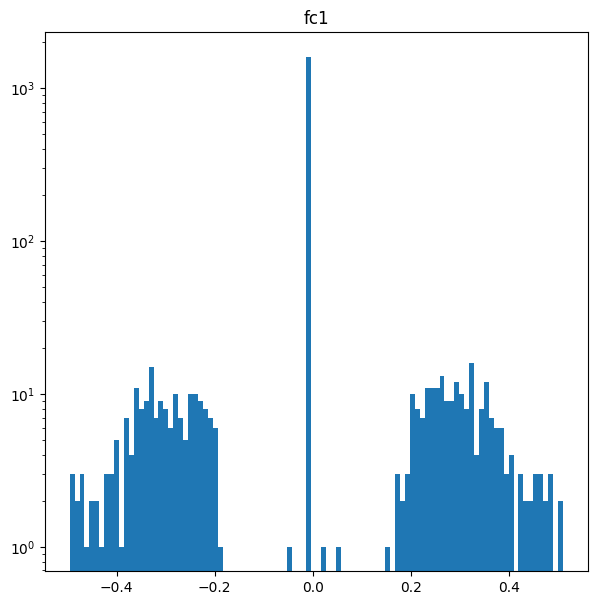

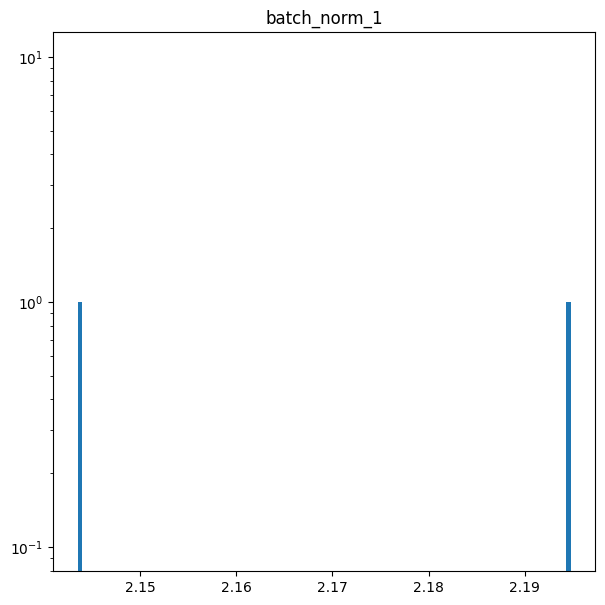

In [20]:
num_layers = len(model.layers)
print(f'Number of layers: {num_layers}')

layer_names = ["fc1", "batch_norm_1"]
for idx in range(num_layers):
    w = model.layers[idx].weights[0].numpy()
    h, b = np.histogram(w, bins=100)

    # plot weight distribution
    plt.figure(figsize=(7, 7))
    plt.bar(b[:-1], h, width=b[1] - b[0])
    plt.title(layer_names[idx])
    plt.semilogy()
    plt.savefig(f'model-dist-idx{idx}.png')

    print('% of zeros = {}'.format(np.sum(w == 0) / np.size(w)))

## Build the HLS model 

In [21]:
sys.path.append("../utils")
from config import print_dict

from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

In [22]:
# Load checkpoint 
co = {}
_add_supported_quantized_objects(co)
model = load_model(CHECKPOINT_FILENAME, custom_objects=co, compile=False)
y_pred = model.predict(X_test)

# Re-evalulate 
y_keras = model.predict(X_test)
print(f'Model acc: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}')
print(model.summary()) 

3157/3157 [==============================] - 3s 1ms/step
Model acc: 0.9581683168316831
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 2)                 2002      
                                                                 
 batch_normalization_1 (Batc  (None, 2)                8         
 hNormalization)                                                 
                                                                 
Total params: 2,010
Trainable params: 2,006
Non-trainable params: 4
_________________________________________________________________
None


In [23]:
# Create HLS configuration 

# Model params: Default precision, reuse factor
HLSConfig = {}
HLSConfig['Model'] = {}
HLSConfig['Model']['Precision'] = 'ap_fixed<16,6>'  # Default precision. Recall syntax: ap_fixed<total_bits, integer_bits>
HLSConfig['Model']['ReuseFactor'] = 1  # fully parallelized 

HLSConfig['LayerName'] = {}
for layer in ['fc1_input', 'fc1', 'fc1_linear', 'batch_normalization']:
    # Layer params: Precision, whether or not to trace
    HLSConfig['LayerName'][layer] = {}
    HLSConfig['LayerName'][layer]['Precision'] = {}
    HLSConfig['LayerName'][layer]['Trace'] = True

# Input - ZCU216 uses 14-bit ADCS  
# Question: 1sn't 16,6 a lot? I remember getting down to like 7 bits total for the GNN tracking project, recreated like 94% accuracy. How accurate do we need to be?
HLSConfig['LayerName']['fc1_input']['Precision'] = 'ap_fixed<14,14>'  # So no fractional bits, prob result of quantization
# Fc
HLSConfig['LayerName']['fc1']['Precision']['result'] = 'ap_fixed<18,18>' 
HLSConfig['LayerName']['fc1']['accum_t'] = 'ap_fixed<18,18>'
# Fc Linear
HLSConfig['LayerName']['fc1_linear']['Precision']['result'] = 'ap_fixed<18,18>'
# Batchnormalization
HLSConfig['LayerName']['batch_normalization']['Precision']['scale'] = 'ap_fixed<20,3>'
HLSConfig['LayerName']['batch_normalization']['Precision']['bias'] = 'ap_fixed<20,3>'
HLSConfig['LayerName']['batch_normalization']['Precision']['result'] = 'ap_fixed<16,6>'

print_dict(HLSConfig)

Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
LayerName
  fc1_input
    Precision:       ap_fixed<14,14>
    Trace:           True
  fc1
    Precision
      result:        ap_fixed<18,18>
    Trace:           True
    accum_t:         ap_fixed<18,18>
  fc1_linear
    Precision
      result:        ap_fixed<18,18>
    Trace:           True
  batch_normalization
    Precision
      scale:         ap_fixed<20,3>
      bias:          ap_fixed<20,3>
      result:        ap_fixed<16,6>
    Trace:           True


In [24]:
OutputDir = 'hls4ml_prj_in500/'
XilinxPart = 'xczu49dr-ffvf1760-2-e' # <-- CHANGE PART HERE
IOType = 'io_parallel' #<-- What are the different options again? io_sequential?
ClockPeriod = 3.225  # 3.225ns (307.2 MHz) # <-- How does this relate to the frequency of the IQ timeseries data? Serialization must be bufferized by WINDOW_SIZE, at least.
            # Is the clock frequency exactly equal to the timeseries frequency? I.e. we sample once per clock cycle until we've bufferized a dataset of size WINDOW_SIZE, and then pass to the NN for inference?
HLSFig = OutputDir+'model.png'

hls_model = hls4ml.converters.convert_from_keras_model(
    model=model,
    hls_config=HLSConfig,
    output_dir=OutputDir,
    part=XilinxPart,
    io_type=IOType,
    clock_period=ClockPeriod,
)

print(f"Creating hls4ml project directory {OutputDir}")
hls_model.compile()  # Must compile for C Sim. 

# Visualize model
hls4ml.utils.plot_model(
    hls_model, show_shapes=True, show_precision=True, to_file=HLSFig
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 1000]], output shape: [None, 1000]
Layer name: fc1, layer type: QDense, input shapes: [[None, 1000]], output shape: [None, 2]
Layer name: batch_normalization_1, layer type: BatchNormalization, input shapes: [[None, 2]], output shape: [None, 2]
Creating HLS model
Creating hls4ml project directory hls4ml_prj_in500/
Writing HLS project


Done


## Check performance

In [25]:
# Trace output 
y_hls = hls_model.predict(np.ascontiguousarray(X_test.astype(np.float32))) 
y_hls = np.argmax(y_hls, axis=1)

print(f'Keras Acc: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))*100:.5}%')
print(f'HLS Acc: {accuracy_score(np.argmax(y_test, axis=1), y_hls)*100:.5}:%')
print(f'CKA: {accuracy_score(np.argmax(y_keras, axis=1), y_hls)*100:.5}%')

Keras Acc: 95.817%
HLS Acc: 49.505:%
CKA: 50.654%


## Correlation plots (Keras vs HLS)
Let's compare the output of the Qkeras and HLS model. If properly configured, the HLS activations will be aligned with the Qkeras model. 

In [26]:
_, hls_trace = hls_model.trace(np.ascontiguousarray(X_test.astype(np.float32))) 
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test.astype(np.float32)) 

print(f'HLS Keys: {hls_trace.keys()}')
print(f'Keras Keys: {keras_trace.keys()}')

Recompiling myproject with tracing
Writing HLS project


Done
3157/3157 [==============================] - 4s 1ms/step
Done taking outputs for Keras model.
HLS Keys: dict_keys(['fc1'])
Keras Keys: dict_keys(['fc1', 'batch_normalization_1'])


fc1 		 90.84688
hls/keras min: -58603.0/-58515.125
hls/keras max: 62226.0/62322.25


KeyError: 'batch_normalization'

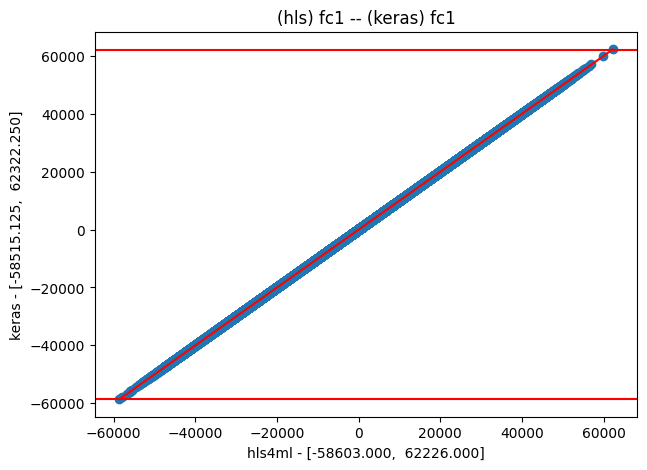

In [27]:
layers = ['fc1', 'batch_normalization']

for idx, layer in enumerate(layers):
    keras_layer, hls_layer = keras_trace[layer], hls_trace[layer]
    try:
        diff = np.average(np.abs(keras_layer - hls_layer ))
        print(f'{layer}', '\t\t', diff)
        
        plt.figure(figsize=(7, 5))

        plt.scatter(hls_layer.flatten(), keras_layer.flatten())
        min_x = min(keras_layer.min(), hls_layer.min())
        max_x = min(keras_layer.max(), hls_layer.max())

        onnx_min, onnx_max = keras_layer.flatten().min(), keras_layer.flatten().max()
        hls_min, hls_max = hls_layer.flatten().min(), hls_layer.flatten().max()
        
        print(f'hls/keras min: {hls_min}/{onnx_min}')
        print(f'hls/keras max: {hls_max}/{onnx_max}')
        
        plt.plot([min_x, max_x], [min_x, max_x], c='red')
        plt.axhline(min_x, c='red')
        plt.axhline(max_x, c='red')

        plt.title(f'(hls) {layer} -- (keras) {layer}')
        plt.xlabel(f'hls4ml - [{hls_min:.3f},  {hls_max:.3f}]')
        plt.ylabel(f'keras - [{onnx_min:.3f},  {onnx_max:.3f}]')
        plt.yscale('linear')
    except Exception as e:
        print(e)


## Synthesize 

In [ ]:
hls_model.build(
    csim=True,
    synth=True,
    cosim=False,
    export=True,
    vsynth=True,
)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1.1 (64-bit)
  **** SW Build 2960000 on Wed Aug  5 22:57:21 MDT 2020
  **** IP Build 2956692 on Thu Aug  6 01:41:30 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /opt/local/Xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/opt/local/Xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'aelabd' on host 'correlator3.fnal.gov' (Linux_x86_64 version 3.10.0-1160.99.1.el7.x86_64) on Wed Mar 06 16:28:19 CST 2024


## Check the report

In [22]:
hls4ml.report.read_vivado_report(f'hls4ml_prj_in500')

Found 1 solution(s) in hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
INFO: Unable to open input/predictions file, using default input.
1.76172 -1.70215 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Tue Mar  5 12:10:35 2024

* Version:        2020.1.1 (Build 2951007 on Wed Aug 05 23:24:06 MDT 2020)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynquplus
* Target device:  xczu49dr-ffvf1760-2-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------